In [113]:
import chess.pgn
import chess.svg
import chess.engine
from IPython.display import SVG
import random, math
import copy

## Read the data

In [2]:
pgn_filename = "../data/lichess_db_head.pgn"
file = open(pgn_filename)
games = []
while True:
    try:
        game = chess.pgn.read_game(file)
    except KeyboardInterrupt:
        raise
    except:
        print("ERROR OCCURRED READING FROM PGN FILE. SKIPPING.")
        continue
    if game is None:
        break
    else:
        games.append(game)
print("Games read: " , len(games))


Games read:  5553


In [3]:
first_game = games[0]
display(first_game.headers)

Headers(Event='Rated Blitz game', Site='https://lichess.org/tGpzk7yJ', Date='????.??.??', Round='?', White='calvinmaster', Black='dislikechess', Result='1-0', BlackElo='1907', BlackRatingDiff='-4', ECO='C34', Opening="King's Gambit Accepted, Schallopp Defense", Termination='Normal', TimeControl='180+0', UTCDate='2017.03.31', UTCTime='22:00:01', WhiteElo='2186', WhiteRatingDiff='+4')

In [4]:
second_game = games[1]
display(second_game.headers)

Headers(Event='Rated Bullet game', Site='https://lichess.org/LzvBtZ93', Date='????.??.??', Round='?', White='Gregster101', Black='flavietta', Result='1-0', BlackElo='1339', BlackRatingDiff='-9', ECO='C34', Opening="King's Gambit Accepted, King's Knight Gambit", Termination='Time forfeit', TimeControl='120+1', UTCDate='2017.03.31', UTCTime='22:00:00', WhiteElo='1385', WhiteRatingDiff='+10')

## Game Setting
- Time control: maybe 2 numbers, like (base time, increment) in seconds
- Player strengths: ELO of self and opponent 

In [62]:
def parseTimeControl(header):
    time_control = header['TimeControl']
    [game_time,move_time] = [int(s) for s in time_control.split('+')]
    return [game_time*60,move_time]

def parseElo(header):
    white_elo = header['WhiteElo']
    black_elo = header['BlackElo']
    return {'white_elo':white_elo,'black_elo':black_elo}

In [63]:
print(parseTimeControl(first_game.headers))
print(parseTimeControl(second_game.headers))

[10800, 0]
[7200, 1]


In [64]:
print(parseElo(first_game.headers))
print(parseElo(second_game.headers))

{'white_elo': '2186', 'black_elo': '1907'}
{'white_elo': '1385', 'black_elo': '1339'}


## Game Status
- Current board
	- Move number - **done**
	- Time left: seconds left for self and opponent. - **done**
	- Color to move: white or black. Unclear if this will help, since it's encoded in the legal moves - **done**
	- Number of legal moves - **done**
	- Check: whether the king is currently in check - **done**
	- Castling rights: 4 yes/no values. Each player might have kingside and/or queenside castling rights. **done**
	- Material: total counts for self and opponent. Maybe use textbook material count, like 1 for pawns, 3 for knights/bishops, 5 for rooks, and 9 for queens. - **done score = [-1,1]**
    - Number of attacking pieces - **done cross-verify**
	- Number of attacked pieces - **done cross-verify**
	- Number of undefended pieces - **done**
	- Stockfish evaluation: static evaluation of position. Would be helpful to get this broken down into components... **Greg is doing this I guess**
- Previous move - **Done - although coded this but I am not sure about the code**
	- Time taken: in seconds **done**
	- Was capture: yes/no. **done**
	- Is threat on undefended piece: yes/no **done**
- Legal moves
    - Stockfish eval: evaluation after reading out variation starting with move. Maybe consider reading to a few depths?
    - Piece: type of piece being moved **done**
    - dx, dy: how far piece is being moved **done**
    - Is capture: yes/no **done**
    - Is threatened: yes/no
    - Is defended: yes/no

In [97]:
def scale_score(cp):
    # [-1,1]
    return (2/(1+math.exp(-0.004 * cp)) - 1)

def materialEval(board):
    eval = 0.0
    eval += len(board.pieces(chess.QUEEN, chess.WHITE)) * 9.0
    eval += len(board.pieces(chess.ROOK, chess.WHITE)) * 5.0
    eval += len(board.pieces(chess.BISHOP, chess.WHITE)) * 3.25
    eval += len(board.pieces(chess.KNIGHT, chess.WHITE)) * 3.0
    eval += len(board.pieces(chess.PAWN, chess.WHITE)) * 1.0
    eval -= len(board.pieces(chess.QUEEN, chess.BLACK)) * 9.0
    eval -= len(board.pieces(chess.ROOK, chess.BLACK)) * 5.0
    eval -= len(board.pieces(chess.BISHOP, chess.BLACK)) * 3.25
    eval -= len(board.pieces(chess.KNIGHT, chess.BLACK)) * 3.0
    eval -= len(board.pieces(chess.PAWN, chess.BLACK)) * 1.0
    eval += random.uniform(0.1, -0.1)
    moves = list(board.pseudo_legal_moves)
    move_val = len(moves)/50.0
    if board.turn:
        return scale_score(eval+move_val)
    else:
        return scale_score(-eval+move_val)

In [98]:
def getNumberofAttackedPieces(board):
    # attack depends on turn
    attackers = 0
    piece_map = board.piece_map() # get all the piece locations
    for square_index, piece in piece_map.items(): 
        if board.turn and piece.symbol().isupper():   # if white turn then find all attacks on white
            attackers += len(board.attackers(chess.BLACK, square_index))
            #print(square_index, ":", piece) 
        elif not board.turn and piece.symbol().islower():  # similar fo black
            attackers += len(board.attackers(chess.WHITE, square_index))
            #print(square_index, ":", piece) 
    return attackers

In [99]:
def getNumberofAttackingPieces(board):
    # attack depends on turn
    attacking_pieces = 0
    piece_map = board.piece_map()
    for square_index, piece in piece_map.items():
        if board.turn and piece.symbol().islower():  # for all white pieces attacking pieces on black occupied sqaures
            attacking_pieces += len(board.attackers(chess.WHITE,square_index))
        elif not board.turn and piece.symbol().isupper(): # for all black pieces attacking pieces on white occupied sqaures
            attacking_pieces += len(board.attackers(chess.BLACK,square_index))
    return attacking_pieces

In [100]:
def getNumberofUndefendedPieces(board):
    undefended_pieces = 0  # assume all are defended LOL :P
    piece_map = board.piece_map()
    for square_index,piece in piece_map.items():
        if board.turn and piece.symbol().isupper():
            undefended_pieces += not board.is_attacked_by(chess.WHITE,square_index) # for all white occupied sqaures check it is attacked by a white piece
        elif not board.turn and piece.symbol().islower():
            undefended_pieces += not board.is_attacked_by(chess.BLACK,square_index)
    return undefended_pieces

In [101]:
# approach - find the sqaure to whcih the piece is moved. Then, find all the sqaures that are attacked from this sqaure. 
# from this set count the number of sqaures which belong to opponent 
def isPreviousMoveThreat(game):
    move = game.move                      # get the move which got us to this board
    board = game.board()
    if game is None or move is None:
        return False
    to_square = move.to_square           # select the sqaure to which the piece is moved
    attacks = board.attacks(to_square)   #find all the sqaures which are attacked by this sqaure
    piece_map = board.piece_map()
    threatened_pieces = 0
    for square_index,piece in piece_map.items(): 
        if board.turn and piece.symbol().isupper(): #if now its white turn, then check attacks on white
            if square_index in attacks: 
                threatened_pieces+=1
        elif not board.turn and piece.symbol().islower(): # if now its black turn, then check if black sqaure belongs to attacks set
            if square_index in attacks: 
                threatened_pieces+=1
        
    if threatened_pieces > 0:
        return True
    return False
    

In [102]:
def getPreviousMoveClockUsed(game):
    # need to go 4 moves back to calculate the time 
    if game is None or game.comment is None:
        return 0
    if game.parent is None or game.parent.comment is None:
        return 0
    if game.parent.parent is None or game.parent.parent.comment is None:
        return 0
    if game.parent.parent.parent is None or game.parent.parent.parent.comment is None:
        return 0
    if game.parent.parent.parent.parent is None or game.parent.parent.parent.parent.comment is None:
        return 0
    
    parent_time= parseComment(game.parent.parent.comment) # this can also be none
    grandparent_time = parseComment(game.parent.parent.parent.parent.comment) # this can also be none in the begining
    if grandparent_time is None or parent_time is None:
        return 0
    
    if game.parent.parent.board().turn != game.parent.parent.parent.parent.board().turn:
        print("turns are not matching....")
    return grandparent_time-parent_time

In [103]:
getNumberofAttackedPieces(first_game.board())

0

In [104]:
getNumberofAttackingPieces(first_game.board())

0

In [105]:
getNumberofUndefendedPieces(first_game.board()) # I think this is correct only rocks are undefended in the starting

2

In [106]:
isPreviousMoveThreat(first_game)

False

In [107]:
def parseLegalMoves(board,move_played):
    legal_features = []
    legal_moves = board.legal_moves
    for legal_move in legal_moves:
        legal_moves_feature  = {}
        from_square = legal_move.from_square
        to_square = legal_move.to_square
        legal_moves_feature['piece_moved'] = board.piece_at(from_square)# can extract color as well if you need
        legal_moves_feature['distance'] = chess.square_distance(from_square,to_square)
        legal_moves_feature['is_capture'] = board.is_capture(legal_move)
        legal_moves_feature['move_executed'] = (move_played.uci() == legal_move.uci()) #only one is this would be true, this is our target also
        #EXTRACT REMAINING FEATURES HERE
        legal_features.append(legal_moves_feature)
    return legal_features

In [114]:
def makeGameLegalFeatures(features,legal_moves_features):
    #replicate game_features many times ...
    all_features = []
    for legal_move_feature in legal_moves_features:
        game_feature = copy.deepcopy(features)
        game_feature.update(legal_move_feature)
        all_features.append(game_feature)
    return all_features
        

In [115]:
def parseTime(time_str):
    [h, m, s] = [int(s) for s in time_str.split(':')]
    return 60*60*h + 60*m + s

def parseComment(comment_str):
    clk_position = comment_str.find('%clk')
    if clk_position == -1:
        return None
    else:
        return parseTime(comment_str[clk_position+5:clk_position+12])

In [116]:
 def parseGame(game):
    game_features = []
    game_legal_moves_features = []
    #game setting
    players_elo = parseElo(game.headers)
    time_control = parseTimeControl(game.headers)
    
    # Infinite time for first move
    white_clock = None
    black_clock = None
    clock_used = None
    
    #game status
    game = game.root() # start from the root
    while not game.is_end():
        features = {}
        board = game.board()
        features["time_control"] = time_control 
        # time for player and opponent
        clock_start = white_clock if board.turn else black_clock
        clock_end = parseComment(game.variations[0].comment) # note_node
        clock_opponent = black_clock if board.turn else white_clock
        
        if clock_start is not None:
            clock_used = clock_start - clock_end
        else:
            clock_used = None
        move = game.move # get the move from the game
        
        # Previous Game features - NOT SURE IF THIS IS DONE CORRECTLY
        if game.parent is not None:
            game_node_parent = game.parent
            parent_board = game_node_parent.board()
            prev_game_clock_used = parseComment(game.comment) - parseComment(game_node_parent.comment) if parseComment(game_node_parent.comment) is not None else 0
            features['prev_move_is_capture'] = parent_board.is_capture(move) # check with previous board current move?
            features['prev_move_clock_used'] = getPreviousMoveClockUsed(game)
            features['prev_move_threat_on_undefended_piece'] = isPreviousMoveThreat(game) # passed currrent game since move inside this game is previous move actually
        else:
            features['prev_move_is_capture'] = False
            features['prev_move_clock_used'] = None
            features['prev_move_threat_on_undefended_piece'] = False
            
        
        features['clock_self'] =  clock_start
        features['clock_opponent']= clock_opponent
        features['clock_used'] = clock_used
        
        if board.turn:
            features.update({'ELO_self': players_elo['white_elo'],'ELO_opponent': players_elo['black_elo']})
        else:
            features.update({'ELO_self' : players_elo['black_elo'],'ELO_opponent': players_elo['white_elo']})
    
        features['number_of_legal_moves'] = board.legal_moves.count()
        features["full_moves"] = board.fullmove_number    #Counts move pairs. Starts at 1 and is incremented after every move of the black side.
        features["check"] = board.is_check()
        features["is_kingside_castle"] = True if move is None else board.is_kingside_castling(move) 
        features["is_queenside_castle"] = True if move is None else board.is_queenside_castling(move)
        features["material"] = materialEval(board)
        features["attacked_pieces"] = getNumberofAttackedPieces(board)
        features["attacking_pieces"] = getNumberofAttackingPieces(board)
        features["undefended_pieces"] = getNumberofUndefendedPieces(board)
        
        #legal moves 
        legal_moves_features = parseLegalMoves(board,game.variations[0].move) #need to send the next move for comparison
        
        if board.turn:
            features['color_to_move'] = "white"
        else:
            features['color_to_move'] = "black"
            
        game_features.append(features)
        all_features = makeGameLegalFeatures(features,legal_moves_features)
        game = game.variations[0] # go to next node
        game_legal_moves_features.append(all_features)
    return game_features,game_legal_moves_features

In [117]:
game_features, game_legal_moves_features = parseGame(second_game)

In [118]:
game_features[20] # game features for game 20

{'time_control': [7200, 1],
 'prev_move_is_capture': False,
 'prev_move_clock_used': 10,
 'prev_move_threat_on_undefended_piece': True,
 'clock_self': None,
 'clock_opponent': None,
 'clock_used': None,
 'ELO_self': '1385',
 'ELO_opponent': '1339',
 'number_of_legal_moves': 39,
 'full_moves': 11,
 'check': False,
 'is_kingside_castle': False,
 'is_queenside_castle': False,
 'material': 0.0017766615044705336,
 'attacked_pieces': 7,
 'attacking_pieces': 2,
 'undefended_pieces': 2,
 'color_to_move': 'white'}

In [119]:
game_legal_moves_features

[[{'time_control': [7200, 1],
   'prev_move_is_capture': False,
   'prev_move_clock_used': None,
   'prev_move_threat_on_undefended_piece': False,
   'clock_self': None,
   'clock_opponent': None,
   'clock_used': None,
   'ELO_self': '1385',
   'ELO_opponent': '1339',
   'number_of_legal_moves': 20,
   'full_moves': 1,
   'check': False,
   'is_kingside_castle': True,
   'is_queenside_castle': True,
   'material': 0.0009995715723782883,
   'attacked_pieces': 0,
   'attacking_pieces': 0,
   'undefended_pieces': 2,
   'color_to_move': 'white',
   'piece_moved': Piece.from_symbol('N'),
   'distance': 2,
   'is_capture': False,
   'move_executed': False},
  {'time_control': [7200, 1],
   'prev_move_is_capture': False,
   'prev_move_clock_used': None,
   'prev_move_threat_on_undefended_piece': False,
   'clock_self': None,
   'clock_opponent': None,
   'clock_used': None,
   'ELO_self': '1385',
   'ELO_opponent': '1339',
   'number_of_legal_moves': 20,
   'full_moves': 1,
   'check': False

# Ignore after this

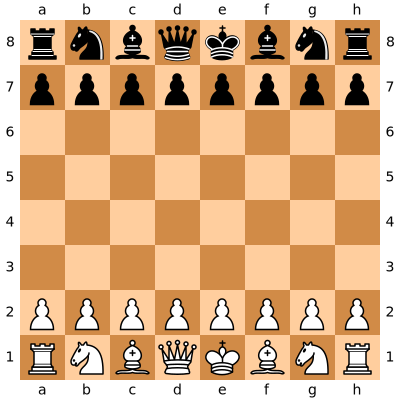

In [100]:


# two chess representations 
board = chess.Board()
SVG(chess.svg.board(board=board,size=400))

#board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 0 4")
#print(board)

## Feature that we can extract 
Check evaluation section : https://www.chessprogramming.org/Evaluation#Side_to_move_relative

## Random Links used frequently
 - https://www.chessprogramming.org/Simplified_Evaluation_Function <\br>
 - https://readthedocs.org/projects/python-chess/downloads/pdf/latest/
 - https://github.com/ShailChoksi/lichess-bot
 - https://chess.stackexchange.com/questions/4653/how-can-i-automatically-extract-features-from-a-position
 - http://www.craftychess.com/
 - https://vision.unipv.it/IA1/ProgrammingaComputerforPlayingChess.pdf

## Preprocessing Features and Playing with fen 
Exploring lichess dataset <br>
Reference : https://github.com/petercunha/stock

In [27]:
pgn_filename = "../data/lichess_db_head.pgn"
file = open(pgn_filename)
games = []
while True:
    try:
        game = chess.pgn.read_game(file)
    except KeyboardInterrupt:
        raise
    except:
        print("ERROR OCCURRED READING FROM PGN FILE. SKIPPING.")
        continue
    if game is None:
        break
    else:
        games.append(game)
print("Games read: " , len(games))

KeyboardInterrupt: 

In [ ]:
# most the parsing done by Greg is great, I am just adding a few functionalities as functions which can be added
engine = chess.engine.SimpleEngine.popen_uci("/home/shivam/UBC/Term2/CPSC540/Assignment/GithubRepo/cpsc-540-ml/project/stockfish/stockfish-11-linux/stockfish-11-linux/Linux/stockfish_20011801_x64")
def getScoreFromStockfish(board,engine):
    info = engine.analyse(board, chess.engine.Limit(time=0.6))
    print("Score:", info["score"]) # we can get move as well from here
    return info["score"] 
    

In [ ]:
for i in range(0,10):
    game = games[i] 
    getScoreFromStockfish(game.board(),engine) # Note : for a game we can be anywhere and find a score

In [ ]:
# represent the board as a row vector according to fen 
game  = games[0]
board = game.end().board() # try to represent the fen as a row vector 64 columns
print(board.fen())

In [ ]:
pgn = open("../data/lichess_db_standard_rated_2017-05.pgn")
first_game = chess.pgn.read_game(pgn)
second_game = chess.pgn.read_game(pgn)
first_game.headers["Event"]
board = first_game.board()
for move in first_game.mainline_moves():
    board.push(move)
board

In [ ]:
second_game.headers

In [ ]:
first_game.is_end()

In [ ]:
game = second_game.end()
board = game.board()

In [ ]:
print('FEN of the last position of the game: ', board.fen())

In [ ]:
from stockfish import Stockfish

In [ ]:
stockfish = Stockfish('/home/shivam/UBC/Term2/CPSC540/Assignment/GithubRepo/cpsc-540-ml/project/stockfish/stockfish-11-linux/stockfish-11-linux/Linux/stockfish_20011801_x64')

In [ ]:
engine = chess.engine.SimpleEngine.popen_uci("/home/shivam/UBC/Term2/CPSC540/Assignment/GithubRepo/cpsc-540-ml/project/stockfish/stockfish-11-linux/stockfish-11-linux/Linux/stockfish_20011801_x64")

In [ ]:
#board = chess.Board()
info = engine.analyse(board, chess.engine.Limit(time=0.1))
print("Score:", info["score"])

In [ ]:
pgnfilename = "../data/lichess_db_standard_rated_2017-05.pgn"
# Game data
pgn = open(infile)
cur_game = chess.pgn.read_game(pgn)
